In [0]:
from torchvision.datasets import utils
import torch.utils.data as data_utils
import torch
import os
import numpy as np
from torch import nn
from torch.nn.modules import upsampling
from torch.functional import F
from torch.optim import Adam
from torchsummary import summary
import torch.optim as optim

In [0]:
def get_data_loader(dataset_location, batch_size):
    URL = "http://www.cs.toronto.edu/~larocheh/public/datasets/binarized_mnist/"
    # start processing
    def lines_to_np_array(lines):
        return np.array([[int(i) for i in line.split()] for line in lines])
    splitdata = []
    for splitname in ["train", "valid", "test"]:
        filename = "binarized_mnist_%s.amat" % splitname
        filepath = os.path.join(dataset_location, filename)
        utils.download_url(URL + filename, dataset_location)
        with open(filepath) as f:
            lines = f.readlines()
        x = lines_to_np_array(lines).astype('float32')
        x = x.reshape(x.shape[0], 1, 28, 28)
        # pytorch data loader
        dataset = data_utils.TensorDataset(torch.from_numpy(x))
        dataset_loader = data_utils.DataLoader(x, batch_size=batch_size, shuffle=splitname == "train")
        splitdata.append(dataset_loader)
    return splitdata

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


In [0]:
#Hyperparameters
batch_size = 64
n_epochs = 20
K=200
log_interval = 100
lr = 3e-4
latent_size = 100
input_size=(1,28,28)

In [279]:
x_train, x_valid, x_test = get_data_loader("binarized_mnist", batch_size)

Using downloaded and verified file: binarized_mnist/binarized_mnist_train.amat
Using downloaded and verified file: binarized_mnist/binarized_mnist_valid.amat
Using downloaded and verified file: binarized_mnist/binarized_mnist_test.amat


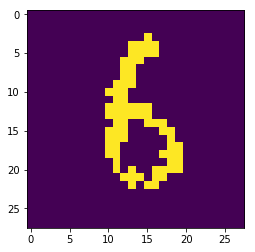

In [6]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
for x in x_train:
    plt.imshow(x[0,0])
    break

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3))
        self.pool1 = nn.AvgPool2d(kernel_size=(2, 2), stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3))
        self.pool2 = nn.AvgPool2d(kernel_size=(2, 2), stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=256, kernel_size=(5, 5))
        self._mean = nn.Linear(in_features=256, out_features=100, bias=True)
        self._logvar = nn.Linear(in_features=256, out_features=100, bias=True)
        self.elu = nn.ELU()

    def forward(self, input):
        input = self.conv1(input)
        input = self.elu(input)
        input = self.pool1(input)
        input = self.conv2(input)
        input = self.elu(input)
        input = self.pool2(input)
        input = self.conv3(input)
        input = self.elu(input)
        input = input.view(input.size(0), -1)
        mean = self._mean(input)
        logvar = self._logvar(input)
        return mean, logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.linear = nn.Linear(in_features=100, out_features=256, bias=True)
        self.conv1 = nn.Conv2d(in_channels=256, out_channels=64, kernel_size=(5, 5), padding=4)
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3, 3), padding=2)
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3, 3), padding=2)
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=(3, 3), padding=2)
        self.elu = nn.ELU()

    def forward(self, input):
        input = self.linear(input)
        input = input.reshape(input.size(0), 256, 1, 1)
        input = self.elu(input)
        input = self.conv1(input)
        input = self.elu(input)
        input = self.upsample1(input)
        input = self.conv2(input)
        input = self.elu(input)
        input = self.upsample2(input)
        input = self.conv3(input)
        input = self.elu(input)
        return torch.sigmoid(self.conv4(input))

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, input):
        mean, logvar = self.encoder(input)
        epsilon = torch.randn_like(logvar)
        input = mean + torch.exp(logvar / 2) * epsilon 
        return self.decoder(input), mean, logvar


In [8]:
model = VAE()
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
summary(model, input_size=input_size)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
               ELU-2           [-1, 32, 26, 26]               0
         AvgPool2d-3           [-1, 32, 13, 13]               0
            Conv2d-4           [-1, 64, 11, 11]          18,496
               ELU-5           [-1, 64, 11, 11]               0
         AvgPool2d-6             [-1, 64, 5, 5]               0
            Conv2d-7            [-1, 256, 1, 1]         409,856
               ELU-8            [-1, 256, 1, 1]               0
            Linear-9                  [-1, 100]          25,700
           Linear-10                  [-1, 100]          25,700
          Encoder-11     [[-1, 100], [-1, 100]]               0
           Linear-12                  [-1, 256]          25,856
              ELU-13            [-1, 256, 1, 1]               0
           Conv2d-14             [-1, 6

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [0]:
#src=https://github.com/pytorch/examples/blob/master/vae/main.py
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp())

    return BCE + KLD

In [0]:
#src=https://github.com/pytorch/examples/blob/master/vae/main.py
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(x_train):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(x_train.dataset),
                100. * batch_idx / len(x_train),
                -loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, -train_loss / len(x_train.dataset)))

In [11]:
for epoch in range(n_epochs):
        train(epoch)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Train Epoch: 0 [0/50000 (0%)]	Loss: -557.901978
Train Epoch: 0 [6400/50000 (13%)]	Loss: -218.308334
Train Epoch: 0 [12800/50000 (26%)]	Loss: -189.404953
Train Epoch: 0 [19200/50000 (38%)]	Loss: -175.412689
Train Epoch: 0 [25600/50000 (51%)]	Loss: -164.643707
Train Epoch: 0 [32000/50000 (64%)]	Loss: -160.002869
Train Epoch: 0 [38400/50000 (77%)]	Loss: -152.281952
Train Epoch: 0 [44800/50000 (90%)]	Loss: -143.354248
====> Epoch: 0 Average loss: -186.7176
Train Epoch: 1 [0/50000 (0%)]	Loss: -141.747772
Train Epoch: 1 [6400/50000 (13%)]	Loss: -134.328323
Train Epoch: 1 [12800/50000 (26%)]	Loss: -134.085159
Train Epoch: 1 [19200/50000 (38%)]	Loss: -129.190674
Train Epoch: 1 [25600/50000 (51%)]	Loss: -118.624695
Train Epoch: 1 [32000/50000 (64%)]	Loss: -124.162689
Train Epoch: 1 [38400/50000 (77%)]	Loss: -115.339905
Train Epoch: 1 [44800/50000 (90%)]	Loss: -111.903313
====> Epoch: 1 Average loss: -127.8042
Train Epoch: 2 [0/50000 (0%)]	Loss: -111.254578
Train Epoch: 2 [6400/50000 (13%)]	Loss

In [12]:
torch.save(model, '/content/model.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type VAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [13]:

model=torch.load('/content/model.pt')
model.eval()
loss = 0
for batch_idx, data in enumerate(x_valid):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss += loss_function(recon_batch, data, mu, logvar).item()
loss = loss/len(x_valid.dataset)
print('Valid - average per-instance ELBO: {} '.format(-loss))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Valid - average per-instance ELBO: -94.52338081054687 


In [463]:

model=torch.load('/content/model.pt')
model.eval()
loss = 0
losses=[]
for batch_idx, data in enumerate(x_test):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss += loss_function(recon_batch, data, mu, logvar).item()
            losses.append(loss)
loss = loss/len(x_valid.dataset)
print('Test - average per-instance ELBO: {} '.format(-loss))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Test - average per-instance ELBO: -93.92628044433594 


In [0]:
#param1: K  the number of importance samples
#param2: mean
#param3: std
#return importance samples of size (M,K,L)
def get_samples(K, mu, std):
    mu = mu.unsqueeze(1).expand(-1, K, -1) 
    std = std.unsqueeze(1).expand(-1, K, -1)    
    return torch.normal(mu, std)

In [0]:
#Evaluating log-likelihood with Variational Autoencoders 
#param1: trained  model
#param2: tensor x of data (M,D)
#param3: tensor z_samples ( M, K, L)
#return (log p(x_), ..., log p(x_M))
def batch_log_px(model, x, z): 
        with torch.no_grad():
              M = x.shape[0]
              D = x.shape[1]
              K = z.shape[1]
              L = z.shape[2]
              mu, logvar = model.encoder(x.reshape((M, 1,28,28)))
              std = torch.exp(logvar / 2)
              mu = mu.unsqueeze(1).expand(-1, K, -1) 
              std = std.unsqueeze(1).expand(-1, K, -1)
              #q(z|x)
              qz_x=(1/torch.sqrt(2*math.pi*std**2))*torch.exp(((z - mu)/std)**2)
              log_qz_x=torch.sum(torch.log(qz_x), -1)
              #p(z)
              pz=(1/math.sqrt(2*math.pi))*torch.exp(z**2)
              log_pz=torch.sum(torch.log(pz), -1)
              #p(x|z)
              recon_x = model.decoder(z.reshape((M*K, L)))
              recon_x= recon_x.reshape((M, K, D))
              log_px_z = torch.sum((x.unsqueeze(1).expand(-1, K, -1) * (recon_x).log() + (1 - x.unsqueeze(1).expand(-1, K, -1)) * (1 - recon_x).log()),-1)
              #log p(x) = log(1/K) + log(sum(exp(log p(x|z)+log p(z)-log q(z|x))))
              log_terms = log_px_z + log_pz - log_qz_x
              max_log,_= log_terms.max(dim=-1, keepdim=True)
              log_px=-np.log(K)+max_log+torch.log(torch.sum(torch.exp(log_terms-max_log)))
        return log_px.mean()

In [0]:
#return (log p(x_1), ..., log p(x_M))
def get_log_px_dataset(data_loader, K):
    log_px_all = []
    for i, x in enumerate(data_loader):
        x = x.to(device)
        mu, logvar = model.encoder(x)
        std = torch.exp(0.5*logvar)
        z = get_samples(K,mu,std)
        log_px_all.append(batch_log_px(model,x.reshape((x.shape[0], -1)),z).cpu().numpy())        
    return log_px_all

In [474]:
log_px_valid = get_log_px_dataset(x_valid, 200)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [476]:
print('Validation -  log-likelihood: {} '.format(np.mean(log_px_valid)))


Validation -  log-likelihood: -72.93242645263672 


In [477]:
log_px_test = get_log_px_dataset(x_test, 200)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [478]:
print('Test -  log-likelihood: {} '.format(np.mean(log_px_test)))


Test -  log-likelihood: -72.61022186279297 
